# TP2 Deep QLearning

Dans ce TP, l'objectif est d'implémenter un agent apprenant à faire atterir un vaisseau sur la lune avec l'algorithme Deep Q-Network. Pour cela vous allez utiliser [PyTorch](https://pytorch.org/) et [Gymnasium](https://gymnasium.farama.org/). 

<img src='lunarlander.png'  width=500px>




# 1. Import des packages

In [3]:
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

def init_seed(seedval):
    torch.manual_seed(seedval)
    np.random.seed(seedval)
    random.seed(seedval)

# 2. Gymnasium

En apprentissage par renforcement, il y a deux concepts fondamentaux : l’agent et l’environnement.
- L’agent est l’entité apprenante qui observe l’environnement et agit sur celui-ci selon les actions disponibles. Son objectif est de maximiser la récompense cumulée qu’il recoit de l’environnement avec lequel il interagit.
- L'agent interagit avec l'environnement à travers la boucle de perception/action ce qui nécessite de définir :
    - Un espace d’action.
    - Un espace d’état (ou observation).
    - Une fonction de récompense.
  
[Gymnasium](https://gymnasium.farama.org/) propose une interface open source unifiée entre un agent et un environnement.
- [Gymnasium](https://gymnasium.farama.org/) propose un ensemble d'environnements pour des tâches d'apprentissage par renforcement. La plupart des environnements ont leur code source disponible sur [GitHub](https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/envs). De nouveaux environnements peuvent aussi être créés à condition qu'ils soient compatibles avec l'interface. 
- Grâce à l'interface unifiée, il est possible de définir indépendamment un agent de l’environnement avec lequel il interagit (et inversement). 
- Lorsque certains pré-traitements sont nécessaires sur les actions, observations, récompenses, ... il est possible d’encapsuler l’environnement dans un **wrapper**, celui-ci se chargera du pré-traitement. 



Dans ce TP, nous allons implémenter un agent qui interagira avec l'environnement [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/). Il existe plusieurs fonctions clé pour interagir avec un environnement.

>  <span style="color:green">Documentation de Gymnasium</span>: [utilisation basique](https://gymnasium.farama.org/content/basic_usage/), [API pour les environnements](https://gymnasium.farama.org/api/env/), ...




##  2.1 - Caractéristiques de l'environnement LunarLander-v2



In [4]:
env = gym.make("LunarLander-v3")

state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n 

state_space = env.observation_space.low, env.observation_space.high

random_state_sample = env.observation_space.sample()
random_action_sample = env.action_space.sample()

print(f"Dimensions de l'espace d'états : {state_dim}")
print(f"Dimensions de l'espace d'actions : {action_dim}")
print(f"Bornes de l'espace d'états : {state_space}")
print(f"Échantillon aléatoire de l'état : {random_state_sample}")
print(f"Échantillon aléatoire de l'action : {random_action_sample}")





Dimensions de l'espace d'états : 8
Dimensions de l'espace d'actions : 4
Bornes de l'espace d'états : (array([ -2.5      ,  -2.5      , -10.       , -10.       ,  -6.2831855,
       -10.       ,  -0.       ,  -0.       ], dtype=float32), array([ 2.5      ,  2.5      , 10.       , 10.       ,  6.2831855,
       10.       ,  1.       ,  1.       ], dtype=float32))
Échantillon aléatoire de l'état : [-1.1854758   0.9583168  -9.1639805   8.396691   -1.2166866   3.4478111
  0.45575386  0.7276543 ]
Échantillon aléatoire de l'action : 3


## 2.2 Interaction et affichage de l'environnement sur un épisode





In [5]:
env = gym.make("LunarLander-v3", render_mode="human")

env.reset()

done = False
total_reward = 0

while not done:
    env.render()
    action = env.action_space.sample()
    state, reward, done, t, info = env.step(action)
    total_reward += reward

print(f"Épisode terminé avec une récompense totale de : {total_reward}")
env.close()



Épisode terminé avec une récompense totale de : -133.86106264137828


# 3. Agent glouton (sans apprentissage)


In [6]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
# import depuis un fichier python local 
from QNN import QNN 
from agentglouton import AgentGlouton
import utils

In [6]:
env = gym.make("LunarLander-v3")

state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n 

epsilon_decay = 0.995
epsilon_end = 0.01
epsilon_start=1.0

agent = AgentGlouton(state_dim,action_dim,epsilon_start)

num_episodes = 4000
liste=[]
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.act_egreedy(state)
        next_state, reward, done, t, info = env.step(action)
        total_reward +=reward
        state = next_state
        done = done or t

    print(f"Episode {episode + 1}, la somme de Reward :{total_reward}")

    agent.epsilon = max(epsilon_end,epsilon_decay*epsilon_start)
    liste.append(total_reward)
env.close()

Episode 1, la somme de Reward :-129.0709170405934
Episode 2, la somme de Reward :-169.38496844230883
Episode 3, la somme de Reward :-134.11092487671053
Episode 4, la somme de Reward :-87.69616070350506
Episode 5, la somme de Reward :-95.89405623436369
Episode 6, la somme de Reward :-218.30309892234737
Episode 7, la somme de Reward :-100.31796136666821
Episode 8, la somme de Reward :-121.36879790786122
Episode 9, la somme de Reward :9.66826248908184
Episode 10, la somme de Reward :-143.57025644030963
Episode 11, la somme de Reward :-279.562946483246
Episode 12, la somme de Reward :-302.0664151489379
Episode 13, la somme de Reward :-119.71747374564389
Episode 14, la somme de Reward :-358.22559728920777
Episode 15, la somme de Reward :-265.5806272712341
Episode 16, la somme de Reward :-334.8764765664183
Episode 17, la somme de Reward :-242.14503525948385
Episode 18, la somme de Reward :-61.13335220421433
Episode 19, la somme de Reward :-216.6298399760759
Episode 20, la somme de Reward :-1

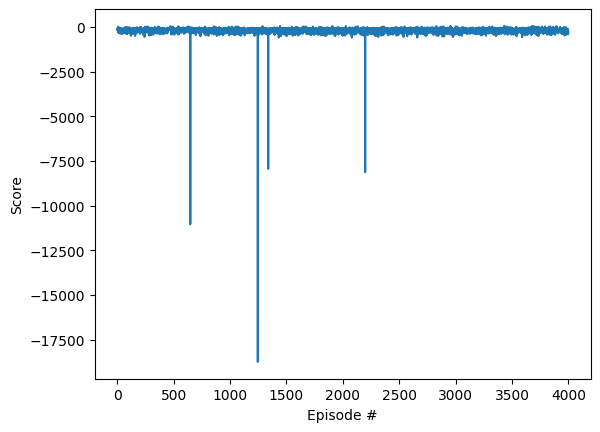

In [7]:
utils.plot_sumrwdperepi(liste)

# 5. Deep QLearning avec Replay Buffer

L'algorithme (sans réseau cible) est donné ci-dessous:

<img src='img/DQN2.png'  width=700px>


In [40]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
from replaybuffer import ReplayBuffer
from agentdqn import AgentDQN

In [52]:
#TODO

def dqnalgo(agent ,env ,nb_episodes ,eps_start ,eps_end , eps_decay):
    """
        Retourne la somme des recompenses par épisode
    """
    my_size = 32 
    liste = []
    for e in range(nb_episodes):
        state,_ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Sélectionner une action
            action = agent.act_egreedy(state,eps_start)

            # Exécuter l'action
            next_state, reward, done, t,a = env.step(action)

            # Ajouter à la mémoire
            agent.sampling_step(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            
            if my_size == 0:
                my_size = 4
                agent.train_step()
            my_size -= 1

            if done:
                print(f"Episode: {e}/{nb_episodes}, total_reward: {total_reward}, Epsilon: {eps_start:.2}")
                break
        liste.append(total_reward)
                
        eps_start = max(eps_end,eps_decay*eps_start)
    env.close()
    return liste

    

In [42]:
env = gym.make("LunarLander-v3")

state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n 

Episode: 0/1000, total_reward: -76.59545034729716, Epsilon: 1.0
Episode: 1/1000, total_reward: -161.0905144638224, Epsilon: 0.1
Episode: 2/1000, total_reward: -310.787965966505, Epsilon: 0.01
Episode: 3/1000, total_reward: -170.24277976891958, Epsilon: 0.01
Episode: 4/1000, total_reward: -533.5646519207876, Epsilon: 0.01
Episode: 5/1000, total_reward: -281.07750694693544, Epsilon: 0.01
Episode: 6/1000, total_reward: -70.85504912885887, Epsilon: 0.01
Episode: 7/1000, total_reward: -308.53851722827596, Epsilon: 0.01
Episode: 8/1000, total_reward: -320.88588789755147, Epsilon: 0.01
Episode: 9/1000, total_reward: -341.0083664803755, Epsilon: 0.01
Episode: 10/1000, total_reward: -239.94470119528341, Epsilon: 0.01
Episode: 11/1000, total_reward: -257.30414240241305, Epsilon: 0.01
Episode: 12/1000, total_reward: -181.31911352714008, Epsilon: 0.01
Episode: 13/1000, total_reward: -332.7182840570064, Epsilon: 0.01
Episode: 14/1000, total_reward: -384.6907751964867, Epsilon: 0.01
Episode: 15/1000

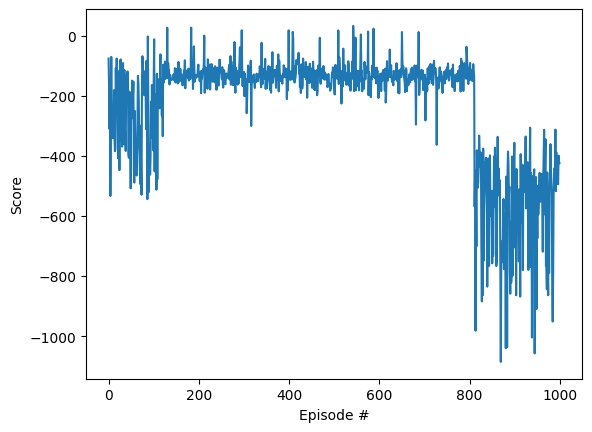

In [25]:
#TOCOMPLETE
gamma=0.95
taille_buffer=10_000
taille_batch = 64
agent = AgentDQN(state_dim, action_dim,taille_buffer, taille_batch)
nb_episodes = 1000
eps_start = 1.0 
eps_end = 0.01 
eps_decay = 0.0995

sumrwd_over_epi= dqnalgo(agent,env,nb_episodes,eps_start,eps_end,eps_decay)
utils.plot_sumrwdperepi(sumrwd_over_epi)


Episode: 0/1000, total_reward: -192.72537705964584, Epsilon: 1.0
Episode: 1/1000, total_reward: -324.01306719983745, Epsilon: 0.1
Episode: 2/1000, total_reward: -111.61056424920051, Epsilon: 0.01
Episode: 3/1000, total_reward: -156.26107908199384, Epsilon: 0.01
Episode: 4/1000, total_reward: -515.3834792269537, Epsilon: 0.01
Episode: 5/1000, total_reward: 18.9406969205843, Epsilon: 0.01
Episode: 6/1000, total_reward: -182.93529080131952, Epsilon: 0.01
Episode: 7/1000, total_reward: -268.18019005279024, Epsilon: 0.01
Episode: 8/1000, total_reward: -68.11872329605139, Epsilon: 0.01
Episode: 9/1000, total_reward: -579.669274859833, Epsilon: 0.01
Episode: 10/1000, total_reward: -138.43931188039573, Epsilon: 0.01
Episode: 11/1000, total_reward: -25.641002121170104, Epsilon: 0.01
Episode: 12/1000, total_reward: -309.6161003927067, Epsilon: 0.01
Episode: 13/1000, total_reward: -119.01428620418051, Epsilon: 0.01
Episode: 14/1000, total_reward: -375.37261102953045, Epsilon: 0.01
Episode: 15/100

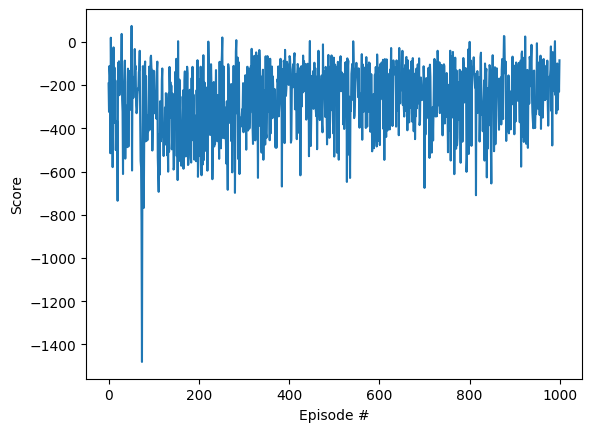

Episode: 0/1000, total_reward: -234.85669525028973, Epsilon: 1.0
Episode: 1/1000, total_reward: -558.9572931795076, Epsilon: 0.1
Episode: 2/1000, total_reward: -555.4896533712451, Epsilon: 0.01
Episode: 3/1000, total_reward: -114.78700028143278, Epsilon: 0.01
Episode: 4/1000, total_reward: -364.97766655342514, Epsilon: 0.01
Episode: 5/1000, total_reward: -342.15519318921963, Epsilon: 0.01
Episode: 6/1000, total_reward: -335.5342996421103, Epsilon: 0.01
Episode: 7/1000, total_reward: -200.74400617527363, Epsilon: 0.01
Episode: 8/1000, total_reward: -513.7207029163862, Epsilon: 0.01
Episode: 9/1000, total_reward: -118.87476567471174, Epsilon: 0.01
Episode: 10/1000, total_reward: -445.0843549140303, Epsilon: 0.01
Episode: 11/1000, total_reward: -425.0520664877537, Epsilon: 0.01
Episode: 12/1000, total_reward: -231.0548034441435, Epsilon: 0.01
Episode: 13/1000, total_reward: -137.07560434239116, Epsilon: 0.01
Episode: 14/1000, total_reward: -405.60468466704344, Epsilon: 0.01
Episode: 15/10

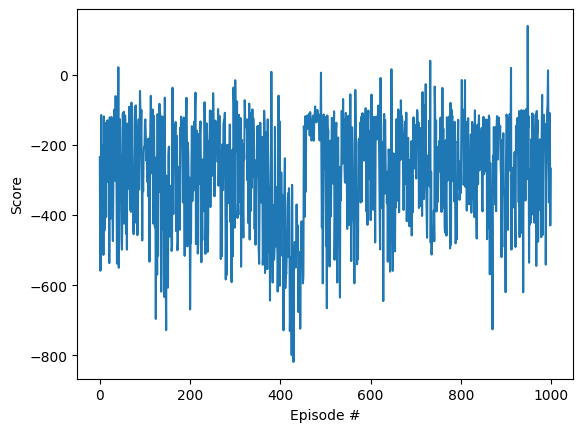

Episode: 0/1000, total_reward: -106.46050564424871, Epsilon: 1.0
Episode: 1/1000, total_reward: -187.5946054539076, Epsilon: 0.1
Episode: 2/1000, total_reward: -148.06456951487814, Epsilon: 0.01
Episode: 3/1000, total_reward: -219.6013028169281, Epsilon: 0.01
Episode: 4/1000, total_reward: -281.0305583389747, Epsilon: 0.01
Episode: 5/1000, total_reward: -254.16062971002452, Epsilon: 0.01
Episode: 6/1000, total_reward: -176.7433686604448, Epsilon: 0.01
Episode: 7/1000, total_reward: -223.54305014786854, Epsilon: 0.01
Episode: 8/1000, total_reward: -112.4214914557175, Epsilon: 0.01
Episode: 9/1000, total_reward: -220.23176665009697, Epsilon: 0.01
Episode: 10/1000, total_reward: -80.13467555823996, Epsilon: 0.01
Episode: 11/1000, total_reward: -455.4671741383365, Epsilon: 0.01
Episode: 12/1000, total_reward: -307.0752933737459, Epsilon: 0.01
Episode: 13/1000, total_reward: -428.7985924569514, Epsilon: 0.01
Episode: 14/1000, total_reward: -188.35978890839567, Epsilon: 0.01
Episode: 15/1000

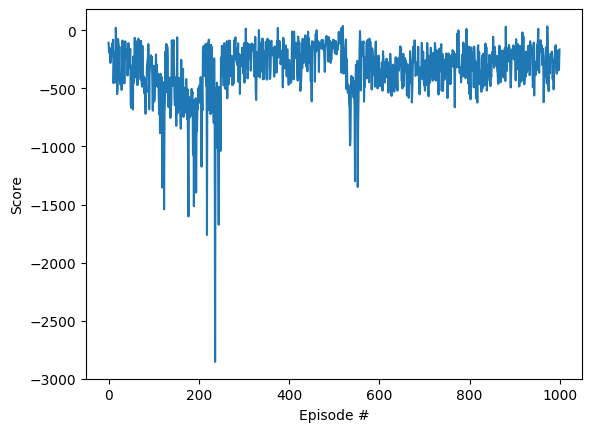

Episode: 0/1000, total_reward: -98.94656363344177, Epsilon: 1.0
Episode: 1/1000, total_reward: -198.18433087138038, Epsilon: 0.1
Episode: 2/1000, total_reward: -131.85251405621483, Epsilon: 0.01
Episode: 3/1000, total_reward: -38.7806834815748, Epsilon: 0.01
Episode: 4/1000, total_reward: -320.636291350486, Epsilon: 0.01
Episode: 5/1000, total_reward: -371.5597207970412, Epsilon: 0.01
Episode: 6/1000, total_reward: -155.08428649863208, Epsilon: 0.01
Episode: 7/1000, total_reward: -571.6164235466756, Epsilon: 0.01
Episode: 8/1000, total_reward: -221.40901954622555, Epsilon: 0.01
Episode: 9/1000, total_reward: -193.53636551679304, Epsilon: 0.01
Episode: 10/1000, total_reward: -83.03297971266777, Epsilon: 0.01
Episode: 11/1000, total_reward: -234.90111800459204, Epsilon: 0.01
Episode: 12/1000, total_reward: -211.81501373404794, Epsilon: 0.01
Episode: 13/1000, total_reward: -286.1909793226855, Epsilon: 0.01
Episode: 14/1000, total_reward: -487.80104179088215, Epsilon: 0.01
Episode: 15/1000

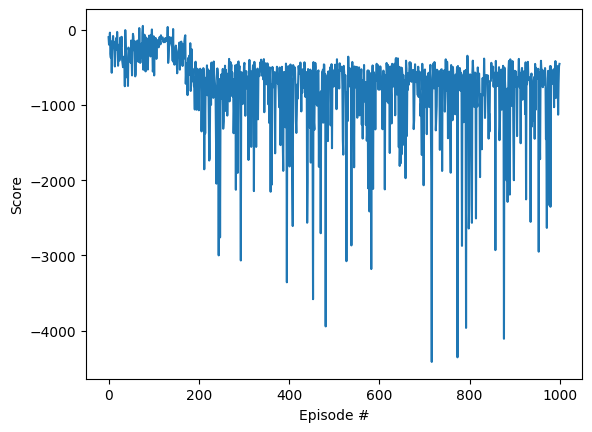

In [26]:
seedval = [2,80,34,10]
for i in seedval:
  init_seed(i)
  agent = AgentDQN(state_dim, action_dim,taille_buffer, taille_batch)
  sumrwd_over_epi= dqnalgo(agent,env,nb_episodes,eps_start,eps_end,eps_decay)
  utils.plot_sumrwdperepi(sumrwd_over_epi)

# 5. Deep QLearning avec réseau cible



L'algorithme DQN (avec réseau cible) est donné ci-dessous:

<img src='img/DQNcible.png'  width=500px>

In [58]:
from agentdqntarget import AgentDQNTarget

Episode: 0/1000, total_reward: -109.60664579981902, Epsilon: 1.0
Episode: 1/1000, total_reward: -550.9571723380906, Epsilon: 0.1
Episode: 2/1000, total_reward: -339.97876457905255, Epsilon: 0.01
Episode: 3/1000, total_reward: -289.8378059131653, Epsilon: 0.01
Episode: 4/1000, total_reward: -223.48734650861627, Epsilon: 0.01
Episode: 5/1000, total_reward: -260.3109048998251, Epsilon: 0.01
Episode: 6/1000, total_reward: -252.24899762594978, Epsilon: 0.01
Episode: 7/1000, total_reward: -243.81153746815053, Epsilon: 0.01
Episode: 8/1000, total_reward: -283.97676749589664, Epsilon: 0.01
Episode: 9/1000, total_reward: -220.9230624342381, Epsilon: 0.01
Episode: 10/1000, total_reward: -259.16243193810305, Epsilon: 0.01
Episode: 11/1000, total_reward: -266.2353693251513, Epsilon: 0.01
Episode: 12/1000, total_reward: -381.4422524422153, Epsilon: 0.01
Episode: 13/1000, total_reward: -252.04979969553276, Epsilon: 0.01
Episode: 14/1000, total_reward: -244.77473447568485, Epsilon: 0.01
Episode: 15/1

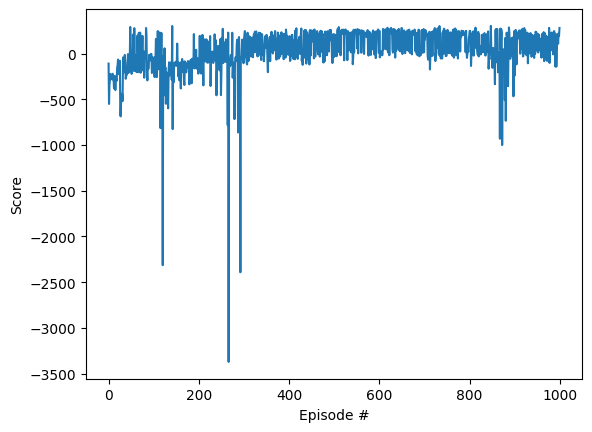

In [59]:
agent = AgentDQNTarget(state_dim, action_dim,0.001,10000, 32)
eps_start = 1.0 
eps_end = 0.01 
eps_decay = 0.0995
nb_episodes = 1000
teu=0.001
sumrwd_over_epi= dqnalgo(agent,env,nb_episodes,eps_start,eps_end,eps_decay)
utils.plot_sumrwdperepi(sumrwd_over_epi)

# 5. Sauvegarde d'un agent
 



In [60]:
#Exemple de code pour sauvegarde d'un réseau
savedfile = 'checkpoint.pth'
torch.save(agent.model.state_dict(), savedfile)


In [61]:
#Exemple de code pour chargement d'un reseau sauvegarde
state_dict = torch.load(savedfile)
agent.model.load_state_dict(state_dict)

<All keys matched successfully>

In [62]:
env = gym.make("LunarLander-v3", render_mode="human")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [63]:
state,_ = env.reset()
done = False
total_reward = 0

while not done:
    state=torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        action = agent.model(state)
        action = np.argmax(action.cpu().data.numpy())
    next_state, reward, done, t, info = env.step(action)
    total_reward +=reward
    state = next_state
    done = done or t
env.close()
print(f"Episode , la somme de Reward :{total_reward}")


Episode , la somme de Reward :158.97673657464074


In [68]:
env = gym.make("LunarLander-v3")

state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n 

Episode: 0/2000, total_reward: -361.3513909429723, Epsilon: 1.0
Episode: 1/2000, total_reward: -492.76907523077995, Epsilon: 0.099
Episode: 2/2000, total_reward: -149.0516896454799, Epsilon: 0.01
Episode: 3/2000, total_reward: -134.9987818041383, Epsilon: 0.01
Episode: 4/2000, total_reward: -97.1661562141607, Epsilon: 0.01
Episode: 5/2000, total_reward: -142.87172490705737, Epsilon: 0.01
Episode: 6/2000, total_reward: -89.85823209510093, Epsilon: 0.01
Episode: 7/2000, total_reward: -193.10371194340047, Epsilon: 0.01
Episode: 8/2000, total_reward: -98.8459049267403, Epsilon: 0.01
Episode: 9/2000, total_reward: -135.03759091771536, Epsilon: 0.01
Episode: 10/2000, total_reward: -104.97390532898626, Epsilon: 0.01
Episode: 11/2000, total_reward: -135.56460690478855, Epsilon: 0.01
Episode: 12/2000, total_reward: -116.57574724477308, Epsilon: 0.01
Episode: 13/2000, total_reward: -152.48577678179123, Epsilon: 0.01
Episode: 14/2000, total_reward: -118.36272801753552, Epsilon: 0.01
Episode: 15/2

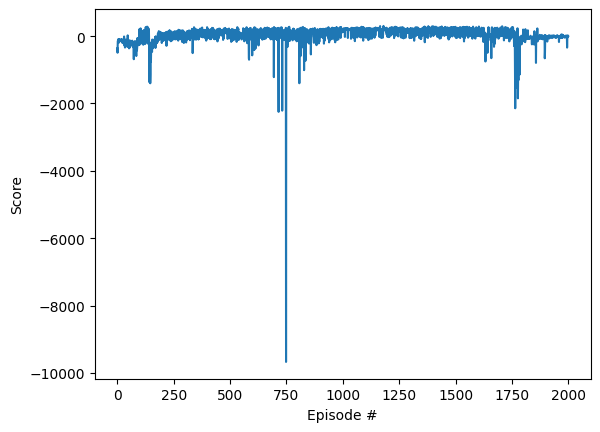

In [69]:
agent = AgentDQNTarget(state_dim, action_dim,0.001,10000, 32)
eps_start = 1.0 
eps_end = 0.01 
eps_decay = 0.0990
nb_episodes = 2000
teu=0.0001
sumrwd_over_epi= dqnalgo(agent,env,nb_episodes,eps_start,eps_end,eps_decay)
utils.plot_sumrwdperepi(sumrwd_over_epi)

In [ ]:
agent = AgentDQNTarget(state_dim, action_dim,0.0001,10000, 32)
eps_start = 1.0 
eps_end = 0.01 
eps_decay = 0.0997
nb_episodes = 1000
sumrwd_over_epi= dqnalgo(agent,env,nb_episodes,eps_start,eps_end,eps_decay)
utils.plot_sumrwdperepi(sumrwd_over_epi)

Episode: 0/1000, total_reward: -162.4795780736965, Epsilon: 1.0
Episode: 1/1000, total_reward: -586.776712000667, Epsilon: 0.1
Episode: 2/1000, total_reward: -129.76497740159638, Epsilon: 0.01
Episode: 3/1000, total_reward: -444.2564771160471, Epsilon: 0.01
Episode: 4/1000, total_reward: -369.6546307243857, Epsilon: 0.01
Episode: 5/1000, total_reward: -283.9121128011154, Epsilon: 0.01
Episode: 6/1000, total_reward: -471.24842702957426, Epsilon: 0.01
Episode: 7/1000, total_reward: -434.9373713858572, Epsilon: 0.01
Episode: 8/1000, total_reward: -509.52866972420367, Epsilon: 0.01
Episode: 9/1000, total_reward: -469.86394522679024, Epsilon: 0.01
Episode: 10/1000, total_reward: -252.60947062826358, Epsilon: 0.01
Episode: 11/1000, total_reward: -419.76333061083886, Epsilon: 0.01
Episode: 12/1000, total_reward: -144.36352318996208, Epsilon: 0.01
Episode: 13/1000, total_reward: -205.88920379065746, Epsilon: 0.01
Episode: 14/1000, total_reward: -218.26943717221513, Epsilon: 0.01
Episode: 15/10